In [1]:
from tamkin import *
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../code/')
from tamkin_multi_fidelity import *

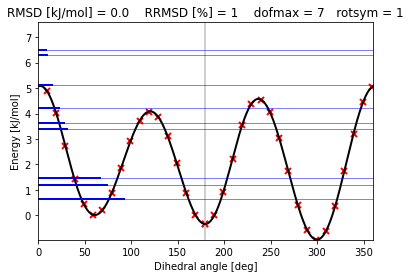

In [2]:
# NpT is used when nothing else is specified (1bar)
monomer = load_molecule_g03fchk("scan_data/ethanolmonomer/mon-p.fchk")
dimer   = load_molecule_g03fchk("scan_data/ethanoldimer/dim-p-p.fchk")
monomer_scan = load_rotscan_g03log("scan_data/ethanolmonomer/mon-p-scan.log")
#monomer_scan = load_rotscan_g03log("mon-np-scan.log")
dimer_scan = load_rotscan_g03log("scan_data/ethanoldimer/dim1-p-p-scan.log", top_indexes= [8])
#dimer_scan = load_rotscan_g03log("dim2-p-p-scan.log")
nma1    = NMA(monomer, ConstrainExt())
nma2    = NMA(dimer, ConstrainExt())
rotor1  = Rotor(monomer_scan, monomer, rotsym=1, even=True, dofmax=7, num_levels = 100)
rotor2  = Rotor(dimer_scan, dimer, rotsym=1, even=False, dofmax=7, num_levels = 100)
pf1rrho = PartFun(nma1, [ExtTrans(), ExtRot(symmetry_number=1)])
pf1     = PartFun(nma1, [ExtTrans(), ExtRot(),rotor1])
pf2rrho = PartFun(nma2, [ExtTrans(), ExtRot(symmetry_number=1)])
pf2     = PartFun(nma2, [ExtTrans(), ExtRot(symmetry_number=1), rotor2])
ta1     = ThermoAnalysis(pf1,     [100, 200, 273.15, 298.15, 310, 400, 500, 1000])
#ta2     = ThermoAnalysis(pf2,     [3, 10, 30, 100, 200, 273.15, 298.15, 310, 400, 500, 1000])
ta2     = ThermoAnalysis(pf2,     [3, 10, 30, 100, 300, 310, 3000])
ta1rrho = ThermoAnalysis(pf1rrho, [100, 200, 273.15, 298.15, 310, 400, 500, 1000])
ta2rrho = ThermoAnalysis(pf2rrho, [100, 200, 273.15, 298.15, 310, 400, 500, 1000])
#ta1.write_to_file("Monomerthermodynamics.csv")
#ta2.write_to_file("Dimerthermodynamics.csv")
#ta1rrho.write_to_file("Monomerthermodynamics_rrho.csv")
#ta2rrho.write_to_file("Dimerthermodynamics_rrho.csv")
#pf1.write_to_file("MonomerPartFun.csv")
#pf2.write_to_file("DimerPartFun.csv")
rotor1.plot_levels("MonomerRotorLevels.png",300)
rotor2.plot_levels("DimerRotorLevels.png",300)




## Two Low Energy Datapoints

This notebook leads to a strategy how to select initial high fidelity sample points

Two data points at the same energy level are not enough for meaningful training, as the relationship between low and high fidelity data cannot be fixed.

An additional data point at a different energy level is necessary for a quantitative description (I think thats actually expected). This also leads to our strategy for selecting the high fidelity points to simulate based on a low fidelity scan:

- global minimum
- global maximum
- local minima (or something else depending on our goal)



# Monomer

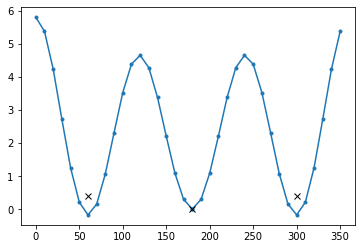

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
angle range: 349.9998885457259
set angle range 360.0


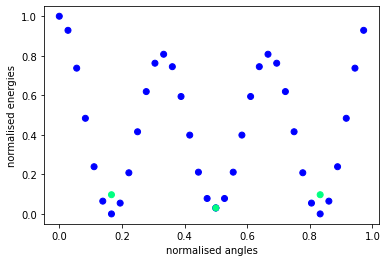

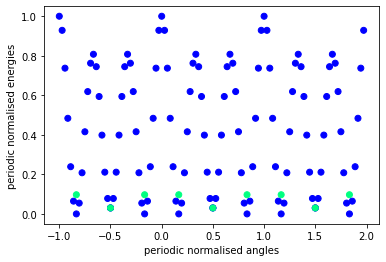

reconstraining parameters gp


(120, 2)
(120, 1)
Optimization restart 1/5, f = -261.63838128026214
Optimization restart 2/5, f = -261.6383714480944
Optimization restart 3/5, f = -261.63837995517144
Optimization restart 4/5, f = -261.63837852683076
Optimization restart 5/5, f = -261.638360231512


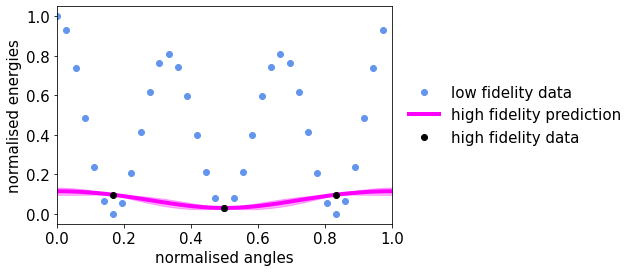

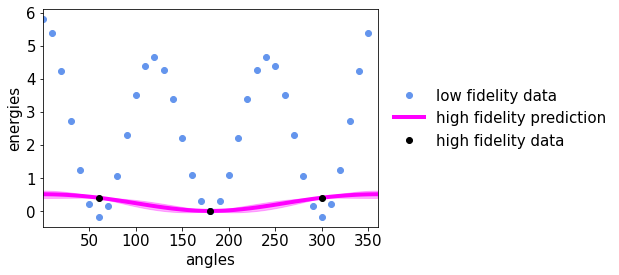

gp.,value,constraints,priors
multifidelity.Mat52.variance,3.9859725334714997,+ve,
multifidelity.Mat52.lengthscale,0.37449887544613064,+ve,
multifidelity.Mat52_1.variance,0.0065557782631825295,+ve,
multifidelity.Mat52_1.lengthscale,0.37897340593283596,+ve,
multifidelity.scale,2.6384961697706426e-07,+ve,
mixed_noise.Gaussian_noise.variance,1e-07,fixed +ve,
mixed_noise.Gaussian_noise_1.variance,1e-07,fixed +ve,


In [7]:
cc_dihedral_monomer = np.array( [60,180,300] )
cc_energy_monomer   = np.array( [0.4, 0., 0.4] )


dihedral_monomer = ( rotor1.rot_scan.potential[0] )/np.pi*180
pp = np.where(dihedral_monomer<0)
dihedral_monomer[pp] = dihedral_monomer[pp] + 360

p = np.argsort( dihedral_monomer )

energy_monomer = rotor1.rot_scan.potential[1]*2625.5002
energy_monomer -= energy_monomer[dihedral_monomer==180] # np.min(energy_monomer)

dihedral_monomer = dihedral_monomer[p]

energy_monomer   = energy_monomer[p]

plt.plot( dihedral_monomer , energy_monomer , ".-" )
plt.plot( cc_dihedral_monomer , cc_energy_monomer , "kx" )
plt.show()
plt.close()

aa = np.concatenate( [dihedral_monomer, cc_dihedral_monomer] )
bb = np.concatenate( [energy_monomer, cc_energy_monomer] )
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral_monomer)), np.ones(len(cc_dihedral_monomer)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei, angle_range=360.0)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern52)

# only positive phi vals
tmf.lin_mf_model.gpy_model.constrain_positive()
# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0000001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("normalised_multi_fidelity_red_fail_0")
tmf.plot_results("multi_fidelity_red_fail_0")

tmf.lin_mf_model.gpy_model



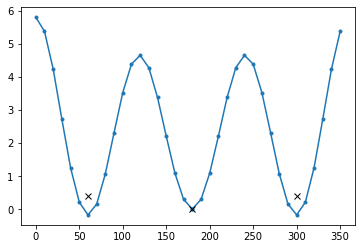

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
angle range: 349.9998885457259
set angle range 360.0


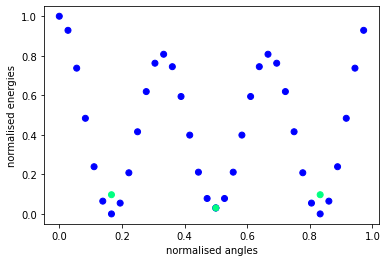

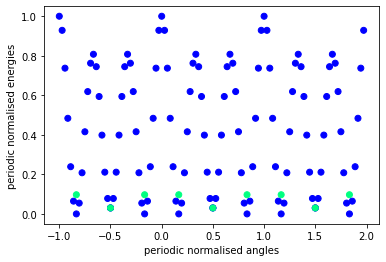

(120, 2)
(120, 1)
Optimization restart 1/5, f = -299.940173063796
Optimization restart 2/5, f = -299.94019295588043
Optimization restart 3/5, f = -299.94017175855606
Optimization restart 4/5, f = -299.940182663342
Optimization restart 5/5, f = -299.94007809473305


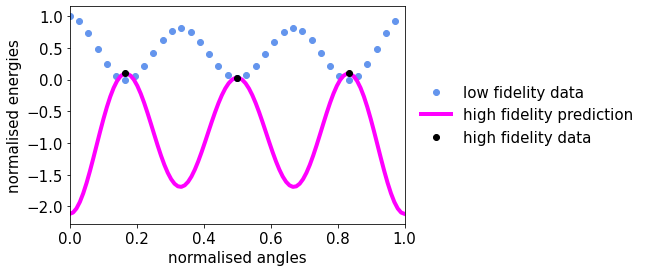

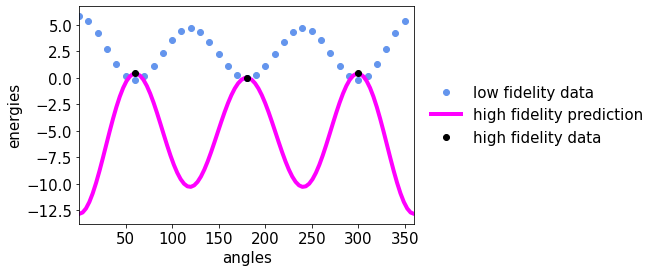

gp.,value,constraints,priors
multifidelity.Mat52.variance,3.99171728986215,+ve,
multifidelity.Mat52.lengthscale,0.37463232430975457,+ve,
multifidelity.Mat52_1.variance,0.00943130349434735,+ve,
multifidelity.Mat52_1.lengthscale,79107.59087896417,+ve,
multifidelity.scale,-2.215394448641092,,
mixed_noise.Gaussian_noise.variance,1e-07,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-07,+ve fixed,


In [8]:
cc_dihedral_monomer = np.array( [60, 180,300] )
cc_energy_monomer = np.array( [ 0.4, 0., 0.4] )


dihedral_monomer = ( rotor1.rot_scan.potential[0] )/np.pi*180
pp = np.where(dihedral_monomer<0)
dihedral_monomer[pp] = dihedral_monomer[pp] + 360

p = np.argsort( dihedral_monomer )

energy_monomer = rotor1.rot_scan.potential[1]*2625.5002
energy_monomer -= energy_monomer[dihedral_monomer==180] # np.min(energy_monomer)

dihedral_monomer = dihedral_monomer[p]

energy_monomer   = energy_monomer[p]

plt.plot( dihedral_monomer , energy_monomer , ".-" )
plt.plot( cc_dihedral_monomer , cc_energy_monomer , "kx" )
plt.show()
plt.close()

aa = np.concatenate( [dihedral_monomer, cc_dihedral_monomer] )
bb = np.concatenate( [energy_monomer, cc_energy_monomer] )
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral_monomer)), np.ones(len(cc_dihedral_monomer)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei, angle_range=360.0)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern52)

# only positive phi vals
#tmf.lin_mf_model.gpy_model.constrain_positive()
# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0000001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("normalised_multi_fidelity_red_fail_1")
tmf.plot_results("multi_fidelity_red_fail_1")

tmf.lin_mf_model.gpy_model


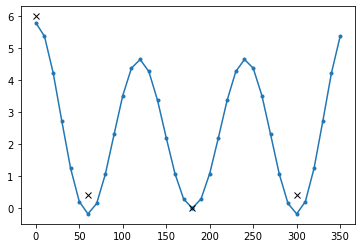

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
angle range: 350.0000070029288
set angle range 360.0


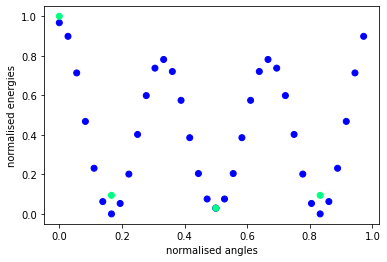

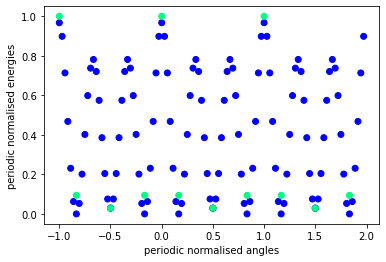

(123, 2)
(123, 1)
Optimization restart 1/5, f = -271.967733992493
Optimization restart 2/5, f = -271.96773400246445
Optimization restart 3/5, f = -271.9677339949103
Optimization restart 4/5, f = -271.96771608738703
Optimization restart 5/5, f = -271.9677339965248


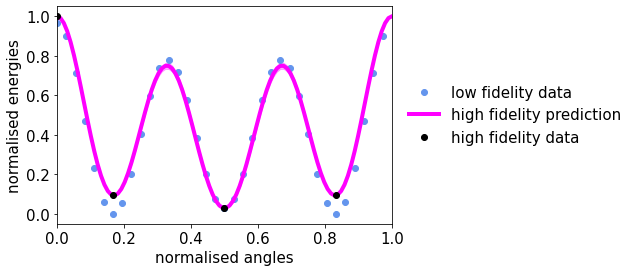

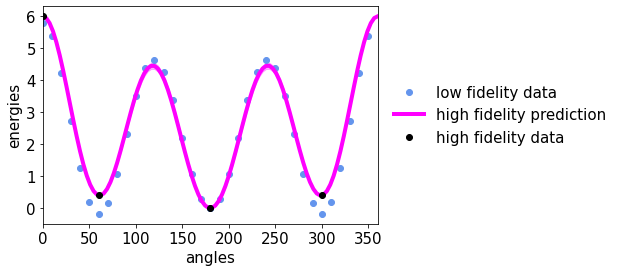

gp.,value,constraints,priors
multifidelity.Mat52.variance,3.7267416571583984,+ve,
multifidelity.Mat52.lengthscale,0.37441445947020696,+ve,
multifidelity.Mat52_1.variance,0.007505651320042367,+ve,
multifidelity.Mat52_1.lengthscale,0.4000326093700727,+ve,
multifidelity.scale,0.9124385375796285,,
mixed_noise.Gaussian_noise.variance,1e-07,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-07,+ve fixed,


In [11]:
cc_dihedral_monomer = np.array( [0.,60,180,300] )
cc_energy_monomer = np.array( [ 6, 0.4, 0., 0.4] )


dihedral_monomer = ( rotor1.rot_scan.potential[0] )/np.pi*180
pp = np.where(dihedral_monomer<0)
dihedral_monomer[pp] = dihedral_monomer[pp] + 360

p = np.argsort( dihedral_monomer )

energy_monomer = rotor1.rot_scan.potential[1]*2625.5002
energy_monomer -= energy_monomer[dihedral_monomer==180] # np.min(energy_monomer)

dihedral_monomer = dihedral_monomer[p]

energy_monomer   = energy_monomer[p]

plt.plot( dihedral_monomer , energy_monomer , ".-" )
plt.plot( cc_dihedral_monomer , cc_energy_monomer , "kx" )
plt.show()
plt.close()

aa = np.concatenate( [dihedral_monomer, cc_dihedral_monomer] )
bb = np.concatenate( [energy_monomer, cc_energy_monomer] )
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral_monomer)), np.ones(len(cc_dihedral_monomer)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei, angle_range=360.0)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern52)

# only positive phi vals
#tmf.lin_mf_model.gpy_model.constrain_positive()
# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0000001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("normalised_multi_fidelity_red")
tmf.plot_results("multi_fidelity_red")

tmf.lin_mf_model.gpy_model

## Adding a High Endergy Datapoint


...leads to meaningful results and confirms the strategy, as the uncertainty in unexplored maxima is high.

# Dimer

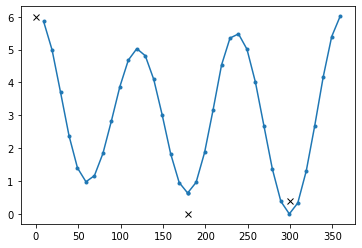

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
angle range: 359.2058796231005
set angle range 360.0


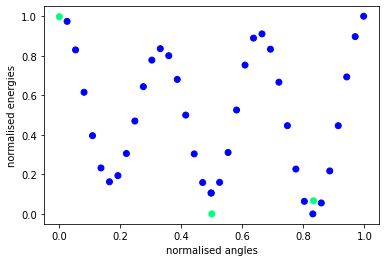

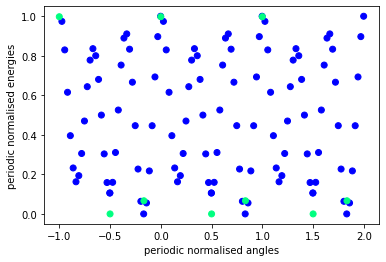

(120, 2)
(120, 1)
Optimization restart 1/5, f = -178.06650776253414
Optimization restart 2/5, f = -178.06650772729887
Optimization restart 3/5, f = -178.0665077689853
Optimization restart 4/5, f = -178.06650749150836
Optimization restart 5/5, f = -177.9611773225987


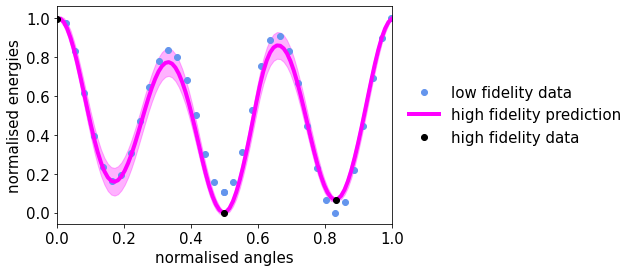

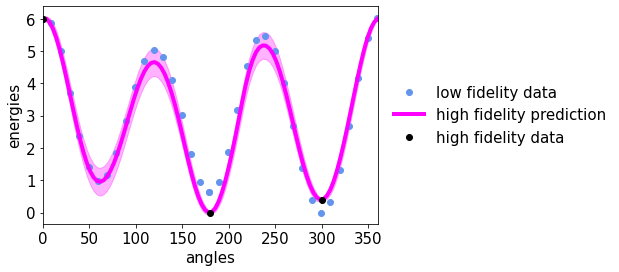

gp.,value,constraints,priors
multifidelity.Mat32.variance,1.0787697906194826,+ve,
multifidelity.Mat32.lengthscale,0.40381675881442336,+ve,
multifidelity.Mat32_1.variance,0.005370939820866926,+ve,
multifidelity.Mat32_1.lengthscale,0.10813754282630529,+ve,
multifidelity.scale,0.9556525978032465,,
mixed_noise.Gaussian_noise.variance,1e-07,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-07,+ve fixed,


In [10]:
cc_dihedral_dimer = np.array( [0,180,300] )
cc_energy_dimer = np.array( [6,0, 0.4] )

dihedral_dimer = ( rotor2.rot_scan.potential[0] )/np.pi*180
pp = np.where(dihedral_dimer<0)
dihedral_dimer[pp] = dihedral_dimer[pp] + 360

p = np.argsort( dihedral_dimer )

energy_dimer = rotor2.rot_scan.potential[1]*2625.5002
energy_dimer -= np.min(energy_dimer)

dihedral_dimer = dihedral_dimer[p]

energy_dimer   = energy_dimer[p]

plt.plot( dihedral_dimer , energy_dimer , ".-" )
plt.plot( cc_dihedral_dimer , cc_energy_dimer , "kx" )
plt.show()
plt.close()

aa = np.concatenate( [dihedral_dimer, cc_dihedral_dimer] )
bb = np.concatenate( [energy_dimer, cc_energy_dimer] )
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral_dimer)), np.ones(len(cc_dihedral_dimer)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei,  angle_range=360.0)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern32)

# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0000001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("dimer_normalised_multi_fidelity_red")
tmf.plot_results("dimer_multi_fidelity_red")

tmf.lin_mf_model.gpy_model